# Changing the spectra per epoch

In [2]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import EarlyStopping




## Convnet function

In [3]:
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units1=256, 
                   dense_units2=128,
                   dense_units3=64,
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units1, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units2:
        model.add(tf.keras.layers.Dense(units=dense_units2, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units3:
        model.add(tf.keras.layers.Dense(units=dense_units3, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [4]:
len_ = 3748
file_list, labels = generate_file_list(limit_per_dir=1)

# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)))

convnet_model.summary()

NameError: name 'generate_file_list' is not defined

In [2]:
# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


In [20]:
train_dataset, val_dataset = generate_random_dataset(lim_per_label = 2000)

Gathering FITS files...
Total spectra files collected: 9299


NameError: name 'split_dataset' is not defined

In [6]:
# Function to train the model with the training and validation datasets
def train_convnet(model, lim_per_label = 2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    train_dataset, val_dataset = generate_random_dataset(lim_per_label = lim_per_label)
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

def train_convnet_many_times(model, epochs_per_run=1, batch_size=32, num_runs=10):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, epochs=epochs_per_run , batch_size=batch_size)
        histories.append(history)
    return histories

## Training it

In [8]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=25)

TypeError: train_convnet_many_times() missing 1 required positional argument: 'val_dataset'

In [31]:
print(train_spectra.shape)



NameError: name 'train_spectra' is not defined

In [50]:
# Save the model
convnet_model.save('convnet_model_v1.keras')

In [29]:
def print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan):   
    # Make predictions on the validation/test dataset
    val_predictions = convnet_model.predict(val_spectranan)

    # Convert the predictions to class labels (assuming one-hot encoding)
    predicted_labels = np.argmax(val_predictions, axis=1)

    # Convert true labels if they are in one-hot encoded format
    true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally, print a classification report for more metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix:
[[389   4   9   0]
 [  2 318   3  76]
 [ 49   4 363   2]
 [  2 143   2 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       402
           1       0.68      0.80      0.73       399
           2       0.96      0.87      0.91       418
           3       0.74      0.60      0.67       371

    accuracy                           0.81      1590
   macro avg       0.82      0.81      0.81      1590
weighted avg       0.82      0.81      0.81      1590



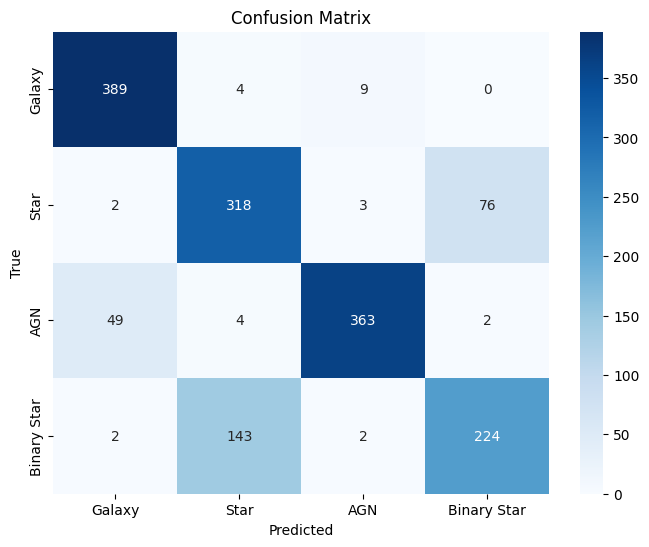

In [49]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# Training very deep convnet

In [1]:
num_labels = 4

filters_20=[512, 512, 512, 512, 512, 512, 256, 256, 256, 128]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=num_labels, num_filters=filters_20, kernel_size=(9,))
model_20.summary()


NameError: name 'create_convnet' is not defined

In [8]:
def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


# Example usage
train_dataset, val_dataset, val_spectranan, val_labelsnan  = generate_datasets_from_preseparated(limit_per_dir=2000)


Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


I0000 00:00:1727873234.727823   64907 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727873234.778447   64907 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727873234.778618   64907 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727873234.781429   64907 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727873234.781502   64907 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/733216059': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/502004210': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/105916146': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/422511057': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/210813155': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/733705124': File-like object does 

2024-10-02 13:47:15.224486: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: pyfunc_514 returns 0 values, but expects to see 1 values.


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/734601208': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/698903222': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/504912236': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/422514234': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/399407162': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/576702003': File-like object does 

2024-10-02 13:47:15.790062: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: pyfunc_1024 returns 0 values, but expects to see 1 values.


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/547209103': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/461107005': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/546605034': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/342506007': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/661710006': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/504909181': File-like object does 

2024-10-02 13:47:16.465515: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: pyfunc_2032 returns 0 values, but expects to see 1 values.


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/574416210': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/629707105': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/230301011': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/471204176': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/469106041': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/star_spectra/258407107': File-like object

2024-10-02 13:47:17.943088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: pyfunc_4134 returns 0 values, but expects to see 1 values.


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/632307140': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/266707192': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/371706186': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/156916011': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/438811199': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/266701182': File-like object does 

Loading spectra:   0%|          | 0/7699 [00:00<?, ?it/s]

Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/381103072': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/388108102': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/284108013': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/469503210': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/580707109': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/bin_spectra/400015093': File-like object does 

InvalidArgumentError: {{function_node __wrapped__EagerPyFunc_Tin_2_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} pyfunc_0 returns 0 values, but expects to see 1 values. [Op:EagerPyFunc]

In [7]:
import os
import random
import numpy as np
import tensorflow as tf
from astropy.io import fits
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values that greately reduce dataset)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


# Example usage
train_dataset, val_dataset, val_spectranan, val_labelsnan  = generate_datasets_from_preseparated(limit_per_dir=2000)




def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan



def generate_file_list(root_dir=".", limit_per_dir=10000):
    spectra_dirs = {
        "training_set/gal_spectra": 0,  # Label 0 for galaxies
        "training_set/star_spectra": 1,  # Label 1 for stars
        "training_set/agn_spectra": 2,   # Label 2 for AGNs
        "training_set/bin_spectra": 3,   # Label 3 for binary stars
        "validation_set/gal_spectra": 0,  # Label 0 for galaxies (validation)
        "validation_set/star_spectra": 1,  # Label 1 for stars (validation)
        "validation_set/agn_spectra": 2,   # Label 2 for AGNs (validation)
        "validation_set/bin_spectra": 3    # Label 3 for binary stars (validation)
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(root_dir, dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value + 0.01) / (mean_value - min_value + 0.01)) - 1  # Avoid negative values
    return normalized_spectra


def load_spectra(file_list, target_length=3748):
    """Load spectra from a list of FITS file paths."""
    spectra_data = []
    for file_path in file_list:
        spectra = load_single_spectrum(file_path, target_length)
        if spectra is not None:
            spectra_data.append(spectra)
    return np.array(spectra_data)

def load_single_spectrum(file_path, target_lenth=3748):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error


def tf_load_single_spectrum(file_path, target_length=3748):
    """TensorFlow wrapper for loading a single spectrum using py_function."""
    spectra = tf.py_function(load_single_spectrum, [file_path, target_length], tf.float32)
    spectra.set_shape([target_length])  # Set the shape explicitly for TensorFlow to optimize
    return spectra


def create_dataset(file_list, labels, batch_size=32, target_length=3748):
    """Create TensorFlow dataset with parallelized loading and optimization."""
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_preprocess(file_path, label):
        spectra = tf_load_single_spectrum(file_path, target_length)
        return spectra, label

    # Apply parallelism and optimizations
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()  # Cache the dataset after loading it once
    dataset = dataset.shuffle(buffer_size=len(file_list))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to overlap data loading and training

    return dataset
def load_all_spectra_parallel(file_list, target_length=3748, max_workers=512):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda f: tf_load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))
    # Filter out None results
    spectra_data = [spectrum for spectrum in results if spectrum is not None]
    return np.array(spectra_data)

# Load the validation dataset once and keep it in memory
def load_validation_dataset(limit_per_label=2000):
    val_dataset = generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[1]
    return val_dataset

# Function to train the model with the training dataset and pre-loaded validation dataset
def train_convnet(model, val_dataset, limit_per_label=2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Load only the training dataset
    train_dataset= generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[0]
    
    # Fit the model using the pre-loaded validation dataset
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10, limit_per_label=2000):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories



In [18]:
val_dataset = load_validation_dataset(limit_per_label=2000)
histories = train_convnet_many_times(model_20, val_dataset, epochs_per_run=10, batch_size=32, num_runs=25)

Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/733705124': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/210813155': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/254814209': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/485006127': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/743407043': File-like object

2024-10-02 13:53:04.727293: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: pyfunc_8195 returns 0 values, but expects to see 1 values.


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/564911216': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/321412134': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/504912236': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/582408029': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/418009052': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/gal_spectra/437705234': File-like object does 

Loading spectra:   0%|          | 0/7699 [00:00<?, ?it/s]

Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/205016040': File-like object does not have a 'write' method, required for mode 'ostream'.

Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/421615074': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/566116180': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/450114039': File-like object does not have a 'write' method, required for mode 'ostream'.Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/187613013': File-like object does not have a 'write' method, required for mode 'ostream'.
Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/573709117': File-like object does 


Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/333004043': File-like object does not have a 'write' method, required for mode 'ostream'.























Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/438804189': File-like object does not have a 'write' method, required for mode 'ostream'.






Error loading b'/home/jcwind/Star Classifier/Star-Classifier/training_set/agn_spectra/101904129': File-like object does not have a 'write' method, required for mode 'ostream'.













































InvalidArgumentError: {{function_node __wrapped__EagerPyFunc_Tin_2_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} pyfunc_7699 returns 0 values, but expects to see 1 values. [Op:EagerPyFunc]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[379   3   5   3]
 [  0 283   0 117]
 [ 44   6 348   2]
 [  4  94   0 302]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       390
           1       0.73      0.71      0.72       400
           2       0.99      0.87      0.92       400
           3       0.71      0.76      0.73       400

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590



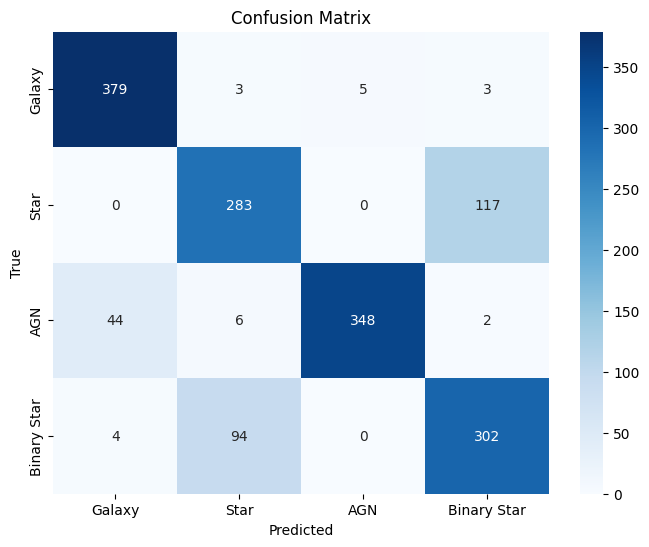

In [61]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# 40 layers for no sane reason

In [61]:
filters_400=[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
model_40 = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)), num_filters=filters_20, dense_units=256, dropout_rate=0.5, kernel_size=(5,))
model_40.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_236 (Conv1D)             │ (None, 3738, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_236               │ (None, 1869, 128)      │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_237 (Conv1D)             │ (None, 1869, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_237               │ (None, 934, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_238 (Conv1D)             │ (None, 934, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_238               │ (None, 467, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_239 (Conv1D)             │ (None, 467, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_239               │ (None, 233, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_240 (Conv1D)             │ (None, 233, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_240               │ (None, 116, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_241 (Conv1D)             │ (None, 116, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_241               │ (None, 58, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_242 (Conv1D)             │ (None, 58, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_242               │ (None, 29, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_243 (Conv1D)             │ (None, 29, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_243               │ (None, 14, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_244 (Conv1D)             │ (None, 14, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_244               │ (None, 7, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_245 (Conv1D)             │ (None, 7, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_245               │ (None, 3, 128)         │             0 │
│ (MaxPooling1D)                  │                        │             

 Total params: 3,201,924 (12.21 MB)

 Trainable params: 3,201,924 (12.21 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=8, num_runs=25)

Training run 1/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 663.98it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8221 - loss: 0.3733 - val_accuracy: 0.8270 - val_loss: 0.3710
Training run 2/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 610.75it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8247 - loss: 0.3899 - val_accuracy: 0.8101 - val_loss: 0.3925
Training run 3/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 569.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8248 - loss: 0.3578 - val_accuracy: 0.8208 - val_loss: 0.3690
Training run 4/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 578.30it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8126 - loss: 0.3990 - val_accuracy: 0.8176 - val_loss: 0.3790
Training run 5/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 629.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8186 - loss: 0.3864 - val_accuracy: 0.8440 - val_loss: 0.3429
Training run 6/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 573.76it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8212 - loss: 0.3783 - val_accuracy: 0.8377 - val_loss: 0.3517
Training run 7/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 572.00it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8329 - loss: 0.3717 - val_accuracy: 0.8472 - val_loss: 0.3462
Training run 8/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 566.44it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8291 - loss: 0.3701 - val_accuracy: 0.8371 - val_loss: 0.3471
Training run 9/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.57it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8219 - loss: 0.3872 - val_accuracy: 0.8245 - val_loss: 0.3859
Training run 10/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 588.42it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8254 - loss: 0.3736 - val_accuracy: 0.8214 - val_loss: 0.3889
Training run 11/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 589.56it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8196 - loss: 0.3836 - val_accuracy: 0.8403 - val_loss: 0.3585
Training run 12/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 658.72it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8327 - loss: 0.3631 - val_accuracy: 0.8478 - val_loss: 0.3431
Training run 13/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 551.85it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8362 - loss: 0.3616 - val_accuracy: 0.8428 - val_loss: 0.3341
Training run 14/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 587.18it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8292 - loss: 0.3771 - val_accuracy: 0.8465 - val_loss: 0.3493
Training run 15/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 650.97it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8372 - loss: 0.3532 - val_accuracy: 0.8390 - val_loss: 0.3616
Training run 16/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 685.20it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8274 - loss: 0.3718 - val_accuracy: 0.8302 - val_loss: 0.3711
Training run 17/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 543.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8205 - loss: 0.3640 - val_accuracy: 0.8308 - val_loss: 0.3512
Training run 18/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 614.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8316 - loss: 0.3633 - val_accuracy: 0.8252 - val_loss: 0.3654
Training run 19/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 576.90it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8473 - loss: 0.3394 - val_accuracy: 0.8453 - val_loss: 0.3317
Training run 20/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 656.38it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8452 - loss: 0.3471 - val_accuracy: 0.8365 - val_loss: 0.3612
Training run 21/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 564.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8273 - loss: 0.3755 - val_accuracy: 0.8447 - val_loss: 0.3422
Training run 22/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 574.48it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8381 - loss: 0.3599 - val_accuracy: 0.8478 - val_loss: 0.3429
Training run 23/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.27it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8341 - loss: 0.3587 - val_accuracy: 0.8396 - val_loss: 0.3395
Training run 24/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 583.34it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8289 - loss: 0.3566 - val_accuracy: 0.8528 - val_loss: 0.3484
Training run 25/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 648.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8413 - loss: 0.3443 - val_accuracy: 0.8509 - val_loss: 0.3357


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[397   0   4   1]
 [  1 293   0 105]
 [ 38   1 376   3]
 [  0  87   0 284]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       402
           1       0.77      0.73      0.75       399
           2       0.99      0.90      0.94       418
           3       0.72      0.77      0.74       371

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590



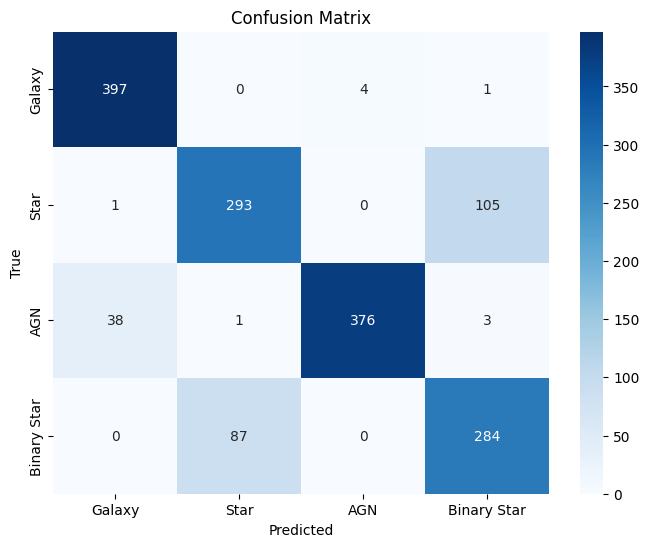

In [60]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)